# Anomaly Detection with Autoencoders

This notebook presents anomaly detection model written in PyTorch library, which can be used e.g. on industrial visual quality inspections.
Model has been trained on MVTec dataset subsets. MVTec consists of 5354 images of different objects and textures.

MVTec dataset: https://www.mvtec.com/company/research/datasets/mvtec-ad

## Imports

In [1]:
import os
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

from skimage.metrics import structural_similarity as ssim

#Setup device to GPU (using cuda) if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset select

Neural network will be trained on one of the MVTec available subsets. In this case, "screw" dataset have been selected.

In [2]:
dataset_name = 'screw' # selected dataset contained in "data/" directory

train_dir = Path(f"data/{dataset_name}/train")
test_dir = Path(f"data/{dataset_name}/test")

## Subdirectories dependencies viewer

In [3]:
def explore_dir(dir_path):
    """
    Function for exploring specified directory dependencies and number of images
    
    Args:
        dir_path (str or Path): Location of interested directory   
    """
    for current_dir, dirs, img in os.walk(dir_path):
        print(f"'{current_dir}' have {len(dirs)} directories and {len(img)} images.")
    print("")

explore_dir(train_dir)
explore_dir(test_dir)

'data\screw\train' have 1 directories and 0 images.
'data\screw\train\good' have 0 directories and 320 images.

'data\screw\test' have 6 directories and 0 images.
'data\screw\test\good' have 0 directories and 41 images.
'data\screw\test\manipulated_front' have 0 directories and 24 images.
'data\screw\test\scratch_head' have 0 directories and 24 images.
'data\screw\test\scratch_neck' have 0 directories and 25 images.
'data\screw\test\thread_side' have 0 directories and 23 images.
'data\screw\test\thread_top' have 0 directories and 23 images.



## View data

Random image path: data\screw\test\good\028.png
Image size: 1024x1024


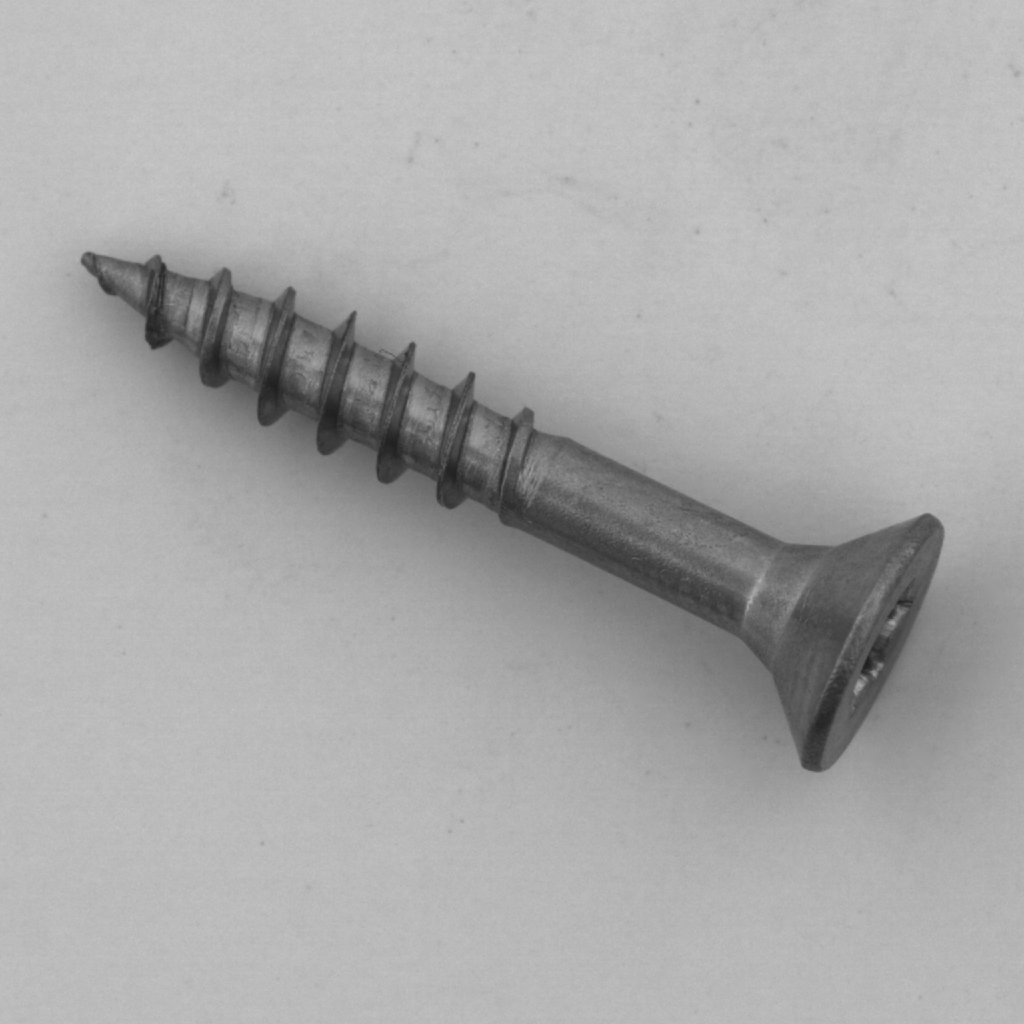

In [4]:
random.seed(42)

images_paths = list(test_dir.glob("*/*.png")) # Gets list of all images paths from train directory
random_image_path = random.choice(images_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image size: {img.height}x{img.width}") 

img

## Data augmentation

Image is converted into greyscale and resized to H=128 and W=128, which later results in [1, 128, 128] input shape.

In [5]:
IMG_RESIZE = 512

data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.Grayscale(1),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

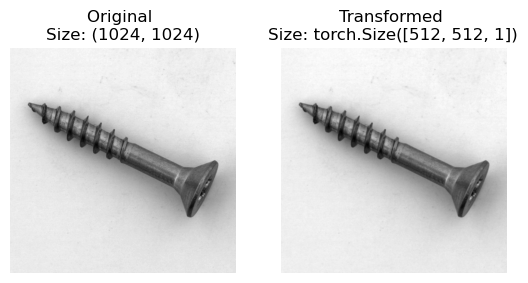

In [6]:
def image_transformation_plot(image_path, transform):
    """
    Plots and compares selected image before and after transformation.
    
    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    transformed_image = transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, data_transform)

## Train and test datasets preparation

In [66]:
def random_crop(data_dir, N_train):
    """
    Function for building dataset with randomly choosen images with applied random crop to (128,128) size.
    
    Args:
        data_dir (str or Path): Location of interested directory
        N_train (int): Number of images in prepared dataset 
    """
    crop_size = (128, 128)

    train_data = []
    images_paths = list(data_dir.glob("*/*.png"))
    
    for i in range(0, N_train):
        random_image_path = random.choice(images_paths)
        img = Image.open(random_image_path)
        img = data_transform(img).squeeze(0)
        
        x_start = random.randint(0, img.shape[0]-crop_size[0])
        y_start = random.randint(0, img.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        
        crop = img[x_start:x_end, y_start:y_end]
        crop = crop.type(torch.float32).unsqueeze(0)
        train_data.append(crop)

    return train_data

In [8]:
# train_data = datasets.ImageFolder(root=train_dir,
#                                   transform=data_transform)

# test_data = datasets.ImageFolder(root=test_dir, 
#                                  transform=data_transform)

# print(f"Train data:\n{train_data}\nTest data:\n{test_data}\n") # Datasets properties summary

# print(f"Image tensor:\n{train_data[0][0]}")
# print(f"Image shape: {train_data[0][0].shape}")
# print(f"Image datatype: {train_data[0][0].dtype}")

## Dataloader

In [8]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

# train_dataloader = DataLoader(dataset=train_data, 
#                               batch_size=BATCH_SIZE, 
#                               num_workers=NUM_WORKERS, 
#                               shuffle=True) 

# test_dataloader = DataLoader(dataset=test_data, 
#                              batch_size=BATCH_SIZE, 
#                              num_workers=NUM_WORKERS, 
#                              shuffle=False)

# images, label = next(iter(train_dataloader))
# print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

X_train = random_crop(data_dir=train_dir, N_train=10000)

train_dataloader = DataLoader(dataset=X_train, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)
images = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

Image shape: torch.Size([32, 1, 128, 128])
 0.13333334028720856
 0.8666666746139526


## Model

In [28]:
class autoencoder_v0(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, 
                      out_channels=32, 
                      kernel_size=4,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d( 32, 32, 4, stride=2, padding=1),            
            nn.LeakyReLU(0.2),
            nn.Conv2d( 32, 32, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 32, 64, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 64, 64, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 128, 64, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 64, 32, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d( 32, 32, 7, stride=1) 
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d( 32, 32, 7, stride=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 32, 64, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 64, 128, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 128, 64, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 64, 64, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 64, 32, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 32, 32, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 32, 32, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d( 32, 1, 4, stride=2, padding=1), 
            nn.Sigmoid()
        )
        
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
     
torch.manual_seed(42)
model = autoencoder_v0()
summary(model, input_size=[BATCH_SIZE, 1, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
autoencoder_v0                           [32, 1, 128, 128]         --
├─Sequential: 1-1                        [32, 32, 2, 2]            --
│    └─Conv2d: 2-1                       [32, 32, 64, 64]          544
│    └─LeakyReLU: 2-2                    [32, 32, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 32, 32, 32]          16,416
│    └─LeakyReLU: 2-4                    [32, 32, 32, 32]          --
│    └─Conv2d: 2-5                       [32, 32, 32, 32]          9,248
│    └─LeakyReLU: 2-6                    [32, 32, 32, 32]          --
│    └─Conv2d: 2-7                       [32, 64, 16, 16]          32,832
│    └─LeakyReLU: 2-8                    [32, 64, 16, 16]          --
│    └─Conv2d: 2-9                       [32, 64, 16, 16]          36,928
│    └─LeakyReLU: 2-10                   [32, 64, 16, 16]          --
│    └─Conv2d: 2-11                      [32, 128, 8, 8]           13

## Train loop

In [29]:
def train_step(model, dataloader, loss_fn, optimizer, epoch):

    model.train()
    train_loss = 0
        
    for img in dataloader:
        
        img = img.to(device)
        recon = model(img)
        loss = loss_fn(recon, img)
        train_loss += loss.item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    outputs.append((epoch, img, recon))
    
    return train_loss

## Training the model

In [30]:
def train(model, train_dataloader, optimizer, loss_fn, epochs):
    
    results = {"train_loss": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                epoch=epoch)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.6f} | "
        )

        results["train_loss"].append(train_loss)

    return results

In [31]:
model = autoencoder_v0().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

outputs = []

In [32]:
NUM_EPOCHS = 200

model_results = train(model=model, 
                    train_dataloader=train_dataloader,
                    optimizer=optimizer,
                    loss_fn=criterion, 
                    epochs=NUM_EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.023554 | 
Epoch: 2 | train_loss: 0.022822 | 
Epoch: 3 | train_loss: 0.022755 | 
Epoch: 4 | train_loss: 0.019641 | 
Epoch: 5 | train_loss: 0.003119 | 
Epoch: 6 | train_loss: 0.002052 | 
Epoch: 7 | train_loss: 0.001734 | 
Epoch: 8 | train_loss: 0.001492 | 
Epoch: 9 | train_loss: 0.001289 | 
Epoch: 10 | train_loss: 0.001197 | 
Epoch: 11 | train_loss: 0.001029 | 
Epoch: 12 | train_loss: 0.000955 | 
Epoch: 13 | train_loss: 0.000865 | 
Epoch: 14 | train_loss: 0.000821 | 
Epoch: 15 | train_loss: 0.000793 | 
Epoch: 16 | train_loss: 0.000748 | 
Epoch: 17 | train_loss: 0.000713 | 
Epoch: 18 | train_loss: 0.000695 | 
Epoch: 19 | train_loss: 0.000745 | 
Epoch: 20 | train_loss: 0.000623 | 
Epoch: 21 | train_loss: 0.000598 | 
Epoch: 22 | train_loss: 0.000601 | 
Epoch: 23 | train_loss: 0.000570 | 
Epoch: 24 | train_loss: 0.000567 | 
Epoch: 25 | train_loss: 0.000541 | 
Epoch: 26 | train_loss: 0.000521 | 
Epoch: 27 | train_loss: 0.000522 | 
Epoch: 28 | train_loss: 0.000525 | 
E

KeyboardInterrupt: 

IndexError: list index out of range

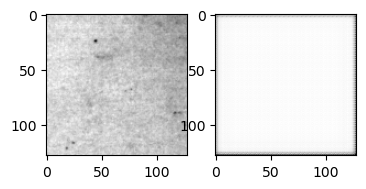

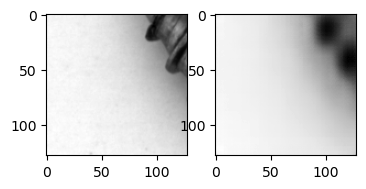

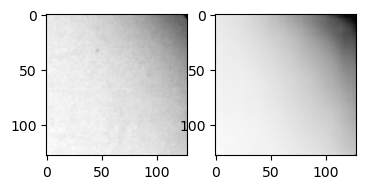

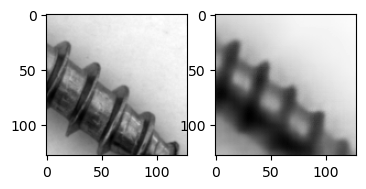

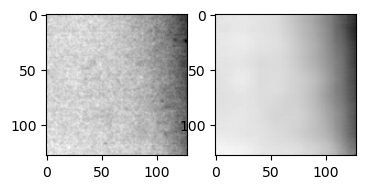

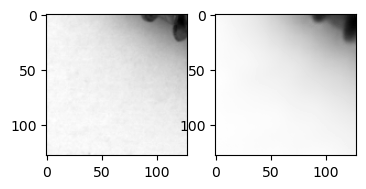

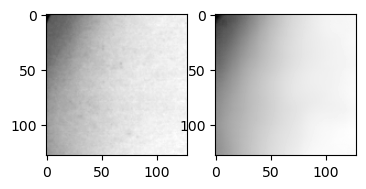

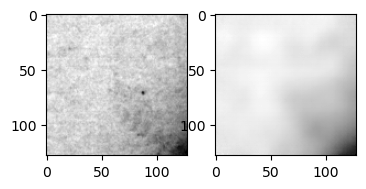

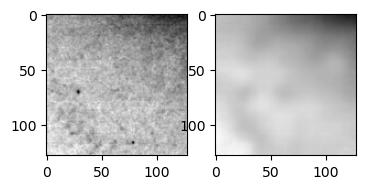

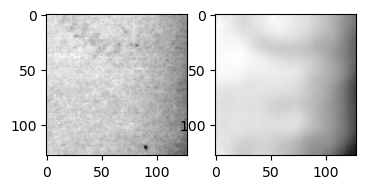

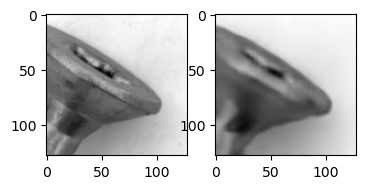

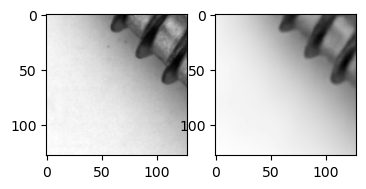

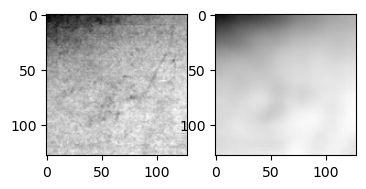

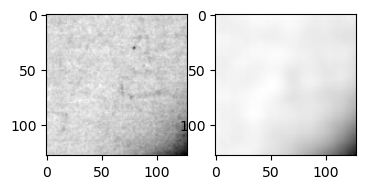

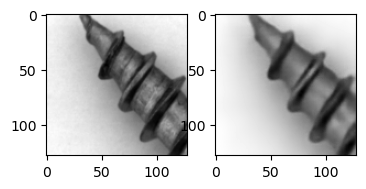

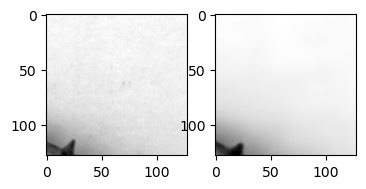

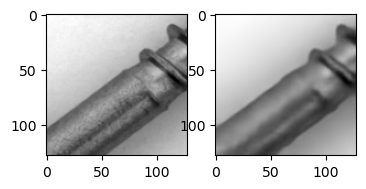

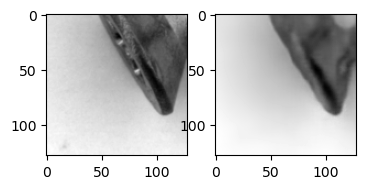

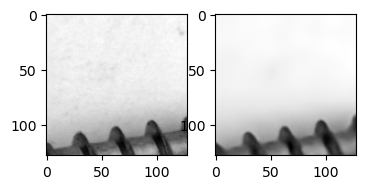

<Figure size 400x400 with 0 Axes>

In [34]:
for k in range(0, NUM_EPOCHS, 10):
    plt.figure(figsize=(4, 4))
    plt.gray()
    imgs = outputs[k][1].detach().cpu()
    recon = outputs[k][2].detach().cpu()
    imgs =  imgs.numpy()
    recon = recon.numpy()
    for i, item in enumerate(imgs):
        if i >= 1: break
        plt.subplot(1, 2, 1)
        plt.imshow(item[0])
     
            
    for i, item in enumerate(recon):
        if i >= 1: break
        plt.subplot(1, 2, 2) 
        plt.imshow(item[0])

## Show Anomalies on Test Data

In [58]:
data_transform_test = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

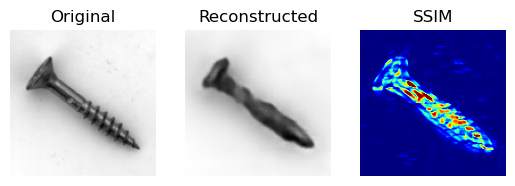

In [65]:
test_image_path = ("data/screw/test/scratch_neck/002.png")

def image_reconstructed_plot(model: torch.nn.Module, 
                             image_path: str,  
                             transform=None,
                             device: torch.device = device):
    
    fig, ax = plt.subplots(1, 3)
    plt.gray()   
    
    img = Image.open(image_path)
    
    if transform:
        img_transformed = transform(img)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        input_image = img_transformed.unsqueeze(dim=0)
        reconstructed = model(input_image.to(device))
        
    original = img_transformed.permute(1, 2, 0).cpu()
    
    ax[0].imshow(original) 
    ax[0].set_title("Original")
    ax[0].axis("off")
    

    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu()
    ax[1].imshow(reconstructed) 
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")
    
    img_old = np.array(original.squeeze(2))
    img_new = np.array(reconstructed.squeeze(2))
    _, _, S = ssim(img_old,img_new, gradient=True, full=True, channel_axis=False)

    ax[2].imshow(1-S, vmax = 1, cmap='jet') 
    ax[2].set_title("SSIM")
    ax[2].axis("off")

    plt.axis(False);
    
image_reconstructed_plot(model=model,
                        image_path=test_image_path,
                        transform=data_transform_test,
                        device=device)